<a href="https://colab.research.google.com/github/fitsumM12/Data-Science/blob/main/Fake%20%20news%20detection_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEPS TO BE FOLLOWED
# 1.IMPORTING LIBRARIES
# 2.DATA PREPROCESSING
# 3.PREPROCESSING AND ANALYSIS OF NEWS COLUMN
# 4.CONVERTING TEXT INTO VECTORS
# 5.MODEL TRAINING, EVALUATION, AND PREDICTION

In [2]:
# IMPORT LIBRARIES
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# LOAD THE DATASET
data = pd.read_csv("/content/drive/MyDrive/FAKE NEWS DETECTION/News.csv", index_col=0)

In [4]:
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [5]:
# DATA PREPROCESSING
# SHAPE OF THE DATASET
data.shape

(44919, 5)

In [6]:
# As the title, subject and date columns will not going to be helpful  in identification of the news. so, we can drop these columns
data = data.drop(['title', 'subject','date'], axis=1)

In [7]:
# NOW, WE HAVE TO CHECK IF THERE IS ANY NULL VALUES
data.isnull().sum()

text     0
class    0
dtype: int64

In [8]:
# Now, we have to shuffle the dataset to prevent the model to get bias.
# After that we will reset the index and then drop it. Becuase index columns is not useful to us
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

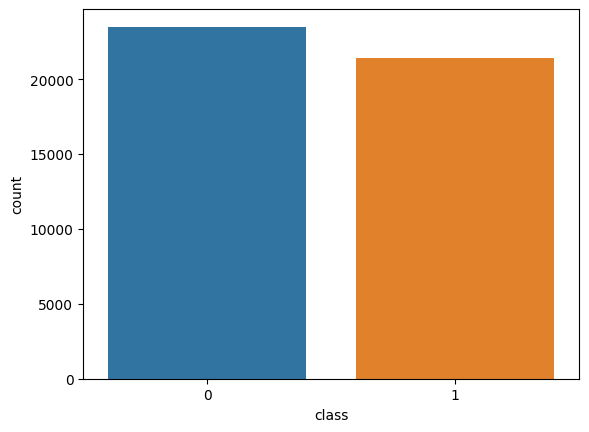

In [9]:
# Now, let explore the unique values in each category 
sns.countplot(data=data, x='class', 
             order = data['class'].value_counts().index)
plt.show()

In [10]:
# PREPROCESSING AND ANALYSIS OF NEWS COLUMNS
# First, we will remove all the stopwords, punctuations and any irrelavant spaces from tvhe text
# From that NLTK library is required and some of its module need to be downloaded

In [11]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [12]:
def preprocess_sentence(sentence):
    # Remove punctuations
    sentence = sentence.translate(sentence.maketrans('', '', string.punctuation))
    # Convert to lowercase
    sentence = sentence.lower()
    # Tokenize sentence
    tokens = word_tokenize(sentence)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join tokens back into a strings
    preprocessed_sentence = ' '.join(lemma_tokens)
    return preprocessed_sentence

In [15]:
# Apply preprocessing on text
data['text'] = data['text'].apply(preprocess_sentence)

In [16]:
data.head()

,text,class
0,game plan republican exactly difficult figure ...,0
1,geneva reuters 30year prison sentence woman el...,1
2,democrat realize lost election america sick in...,0
3,radical baltimore mayor ordered baltimore poli...,0
4,,0


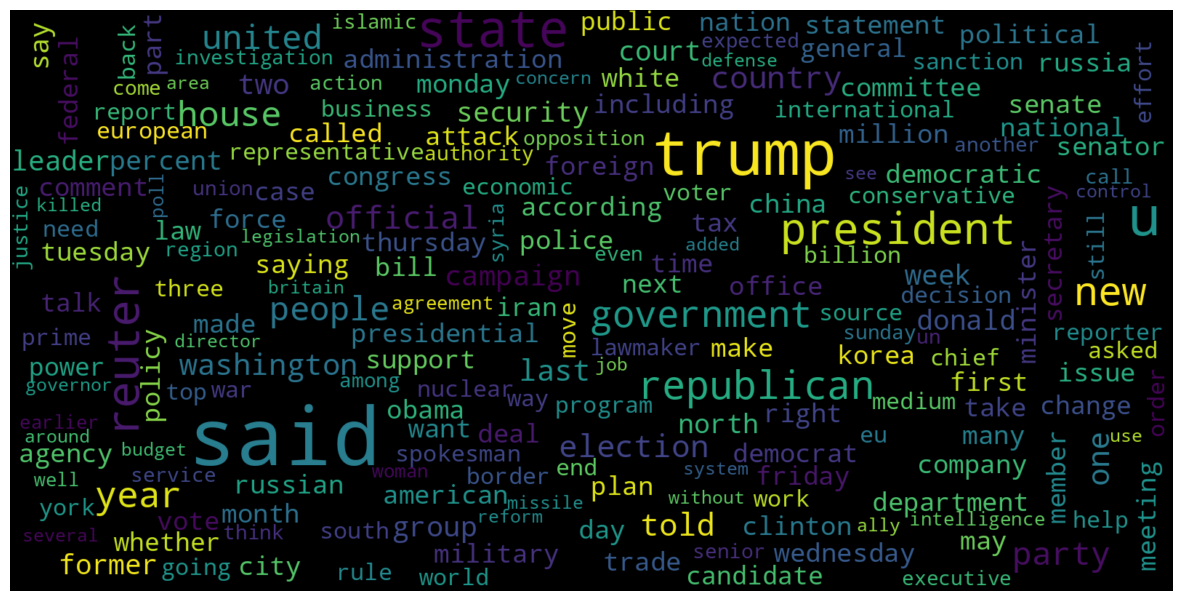

In [17]:
# Real News Visualization
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

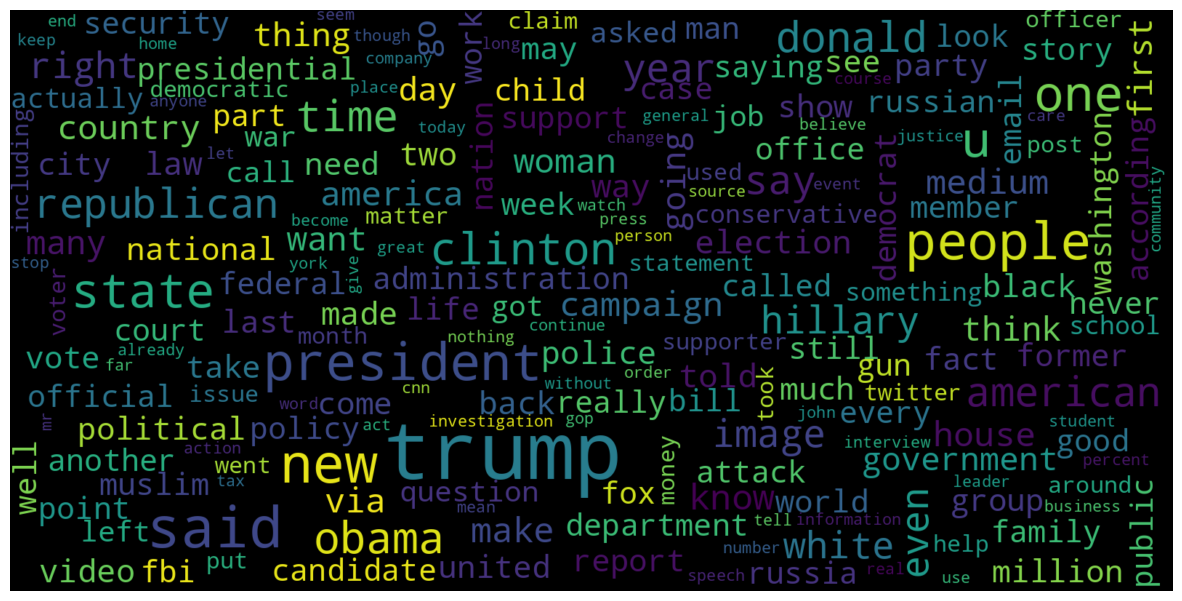

In [19]:
# Fake News Visualization
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

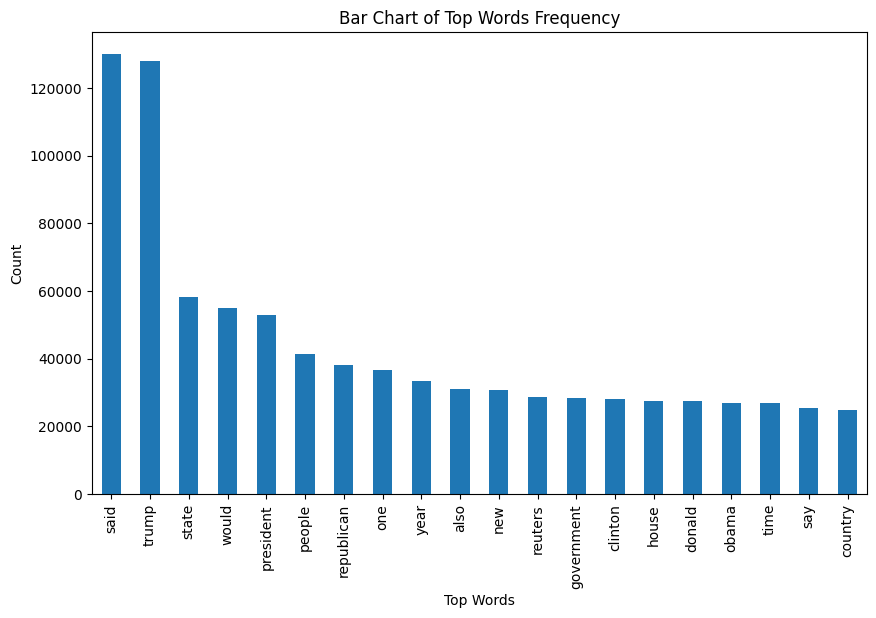

In [20]:
# Now, Let’s plot the bargraph of the top 20 most frequent words.
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]
  
  
common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])
  
df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

In [23]:
# Converting text into Vectors

# Before converting the data into vectors, split it into train and test.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
  
x_train, x_test, y_train, y_test = train_test_split(data['text'], 
                                                    data['class'], 
                                                    test_size=0.25)

In [24]:
# Now we can convert the training data into vectors using TfidfVectorizer.
from sklearn.feature_extraction.text import TfidfVectorizer
  
vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [25]:
# Model training, Evaluation, and Prediction

# Now, the dataset is ready to train the model.

# For training we will use Logistic Regression and evaluate the prediction accuracy using accuracy_score.
from sklearn.linear_model import LogisticRegression
  
model = LogisticRegression()
model.fit(x_train, y_train)
  
# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9909762830597525
0.986286731967943


In [26]:
# Let’s train with Decision Tree Classifier. 
from sklearn.tree import DecisionTreeClassifier
  
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
  
# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9999703167205913
0.9956366874443455


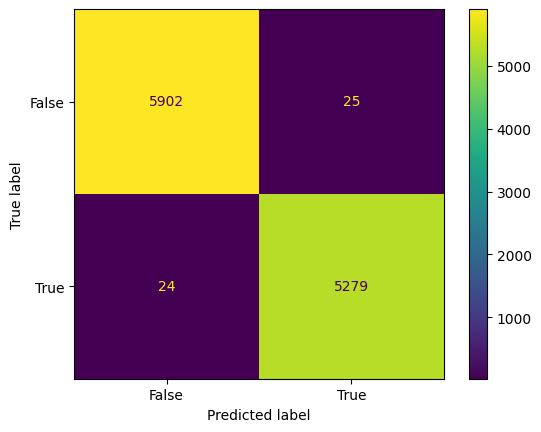

In [27]:
# The confusion matrix for Decision Tree Classifier can be implemented with the code below.
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot()
plt.show()